# Figure 7.
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/22/2025          |
| Updated |  08/22/2025          |

Total radiation energy density $E_\mathrm{r,tot}$ [equation (24)] as a function of time for hydrostatic models that include frequency-dependent absorption and scattering opacities across $N_f = 64$ bands.
The blue curve shows the case for radiative attenuation only (i.e., without dust heating), the orange shows that for absorption (i.e., with dust thermal reemission), the dotted gray vertical line shows the light-crossing time $t_\mathrm{cross}$ for the 90 au radial domain (Section 3.3), and the dashed black vertical line marks when thermal equilibrium is reached at $t_\mathrm{eq}$ (Section 4.4.3).
Note that $t$ is multiplied by 1% (our `reduced_factor`) to account for using a reduced speed of light (Sections 3.3 and 4.5).

t_cross = 4.5e+04 s
   t_eq = 2.5e+05 s
  t_lim = 6.5e+05 s


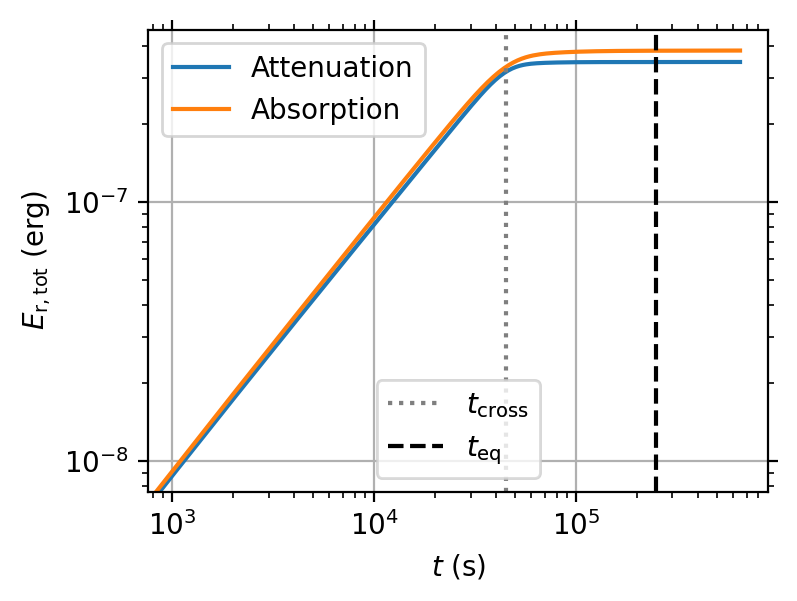

In [ ]:
#===============================================================================
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# Constants
arad = 7.565733250033928e-15  # radiation constant
au = 1.495978707e13           # astronomical unit [cm]
c = 2.99792458e10             # speed of light [cm/s]

# Conversions
def t2s(t):
    return t*length_unit/cs_iso

def E2erg(E):
    return E*arad*t_unit**4

# Read and plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
problem_id = 'dsharp'
root = '../athena/models/dsharp_abs-sca/nfreq'
runs = [['64-no_heat', 'Attenuation'], ['64', 'Absorption']]
c_solns = []

for i, run in enumerate(runs):
    path = f'{root}/{run[0]}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    reduced_factor = athinput['radiation']['reduced_factor']
    length_unit = athinput['radiation']['length_unit']
    molecular_weight = athinput['radiation']['molecular_weight']
    r_ideal = 8.314462618e7/molecular_weight
    t_unit = athinput['radiation']['T_unit']
    cs_iso = (r_ideal*t_unit)**0.5
    hst = athena_read.hst(f'{path}/output/{problem_id}.hst')
    Er = hst['Er']
    if 'n_frequency' in athinput['radiation']:
        nfreq = athinput['radiation']['n_frequency']
        Er = Er.reshape(-1, nfreq)
        Er = Er.sum(axis=1)
    t_adj = hst['time']*reduced_factor
    c_solns.append(ax.plot(t2s(t_adj), E2erg(Er), label=f'{run[1]}')[0])

# Compute light crossing time for oblique beams
lx = athinput['mesh']['x1max'] - athinput['mesh']['x1min']
with open(f'{path}/output/Rad_angles.txt') as Rad_angles:
    lines = Rad_angles.read().splitlines()
    crat = float(lines[2].split()[1])
t_cross = lx/crat
ax.axvline(t2s(t_cross*reduced_factor), color='tab:gray', ls='dotted')
ax.axvline(2.5e5, color='black', ls='dashed')

# Diagnostics
print(f't_cross = {90*au/c:.1e} s')
print(f'   t_eq = {t2s(3.8248953850990287e-02*reduced_factor):.1e} s')
print(f'  t_lim = {t2s(t_adj[-1]):.1e} s')

# Plot ghost point(s) for colorless linestyles
ref_soln = []
ref_soln.append(ax.plot([], [], 'tab:gray', ls='dotted',
                label=r'$t_\mathrm{cross}$')[0])
ref_soln.append(ax.plot([], [], 'black', ls='dashed',
                label=r'$t_\mathrm{eq}$')[0])
ax.add_artist(plt.legend(handles=c_solns, loc='upper left'))
ax.add_artist(plt.legend(framealpha=0.56, handles=ref_soln, loc='lower center'))

# Format plots
ax.grid()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
ax.set(xlabel=r'$t$ (s)', ylabel=r'$E_\mathrm{r,tot}$ (erg)', xscale='log',
       yscale='log')
plt.savefig('figs/evolution.pdf', bbox_inches='tight', pad_inches=0.01)
#===============================================================================